In [1]:
%matplotlib inline

In [2]:
# update PATH with location of dot utility
current_path = %env PATH
%env PATH=/opt/conda/envs/onnx_training/bin:$current_path

env: PATH=/opt/conda/envs/onnx_training/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


# Test building custom onnx models

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import onnx
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
import onnxruntime as ort

## Define the ONNX Model

In [4]:
from skl2onnx.algebra.onnx_ops import OnnxAdd, OnnxTranspose  # noqa
from skl2onnx.common.data_types import FloatTensorType

# Create place holders for the input variables
X = onnx.helper.make_tensor_value_info('X', onnx.TensorProto.FLOAT, [None, 2])
Y = onnx.helper.make_tensor_value_info('Y', onnx.TensorProto.FLOAT, [None, 2])

add_node = OnnxAdd('X', 'Y',output_names=['Sum1'], op_version=10)

model_def = add_node.to_onnx({'X':X, 'Y':Y}, target_opset=10)
onnx.checker.check_model(model_def)
print(f'model:\n{model_def}')

model:
ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.10.3"
domain: "ai.onnx"
model_version: 0
graph {
  node {
    input: "X"
    input: "Y"
    output: "Sum1"
    name: "Ad_Add"
    op_type: "Add"
    domain: ""
  }
  name: "OnnxAdd"
  input {
    name: "X"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
          }
          dim {
            dim_value: 2
          }
        }
      }
    }
  }
  input {
    name: "Y"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
          }
          dim {
            dim_value: 2
          }
        }
      }
    }
  }
  output {
    name: "Sum1"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
          }
          dim {
            dim_value: 2
          }
        }
      }
    }
  }
}
opset_import {
  domain: ""
  version: 10
}



In [5]:
X_in = np.arange(6).reshape(-1,2).astype(np.float32)
Y_in = 10*X_in
print(f'X=\n{X_in},\nY=\n{Y_in}')
print(f'sum=\n{X_in + Y_in}')

X=
[[0. 1.]
 [2. 3.]
 [4. 5.]],
Y=
[[ 0. 10.]
 [20. 30.]
 [40. 50.]]
sum=
[[ 0. 11.]
 [22. 33.]
 [44. 55.]]


## Make Prediction

In [6]:
X_in.shape

(3, 2)

In [7]:
sess = ort.InferenceSession(model_def.SerializeToString())
names = [i.name for i in sess.get_inputs()]
dinputs = {name: input for name, input in zip(names, [X_in, Y_in])}
res = sess.run(None, dinputs)
names = [o.name for o in sess.get_outputs()]
prediction = {name: output for name, output in zip(names, res)}

prediction

{'Sum1': array([[ 0., 11.],
        [22., 33.],
        [44., 55.]], dtype=float32)}

In [8]:
[i.name for i in sess.get_inputs()]

['X', 'Y']

In [9]:
[o.name for o in sess.get_outputs()]

['Sum1']

## Display graph

(-0.5, 963.5, 1033.5, -0.5)

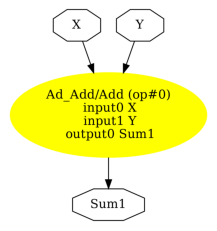

In [10]:
pydot_graph = GetPydotGraph(
    model_def.graph, name=model_def.graph.name, rankdir="TB",
    node_producer=GetOpNodeProducer("docstring", color="yellow",
                                    fillcolor="yellow", style="filled"))
pydot_graph.write_dot("my_model.dot")

os.system('dot -O -Gdpi=300 -Tpng my_model.dot')

image = plt.imread("my_model.dot.png")
fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(image)
ax.axis('off')

## Two node model

In [11]:
# Preprocessing: create a model with two nodes, Y's shape is unknown
# get sum of two matrices
node1 = onnx.helper.make_node('Add', ['X', 'Y'], ['Sum1'])

# get transpose of matrix sum
node2 = onnx.helper.make_node('Transpose', ['Sum1'], ['Z'], perm=[1, 0])

graph = onnx.helper.make_graph(
    [node1, node2],    # nodes in the graph
    'add-transpose',  # graph name
    [
        onnx.helper.make_tensor_value_info('X', onnx.TensorProto.FLOAT, (None, 2)),
        onnx.helper.make_tensor_value_info('Y', onnx.TensorProto.FLOAT, (None, 2)),        
    ],  # inputs
    [onnx.helper.make_tensor_value_info('Z', onnx.TensorProto.FLOAT, (None, 3))], # outputs
)

onnx_model = onnx.helper.make_model(graph, producer_name='two-node-model')

# Check the model and print output shape information
#print(f'the model is:\n{onnx_model}')
onnx.checker.check_model(onnx_model)

(-0.5, 882.5, 1796.5, -0.5)

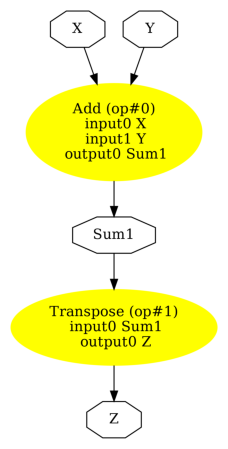

In [12]:
pydot_graph = GetPydotGraph(
    onnx_model.graph, name=onnx_model.graph.name, rankdir="TB",
    node_producer=GetOpNodeProducer("docstring", color="yellow",
                                    fillcolor="yellow", style="filled"))
pydot_graph.write_dot("my_model.dot")

os.system('dot -O -Gdpi=300 -Tpng my_model.dot')

image = plt.imread("my_model.dot.png")
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)
ax.axis('off')

In [13]:
sess = ort.InferenceSession(onnx_model.SerializeToString())
names = [i.name for i in sess.get_inputs()]
dinputs = {name: input for name, input in zip(names, [X_in, Y_in])}
res = sess.run(None, dinputs)
names = [o.name for o in sess.get_outputs()]
prediction = {name: output for name, output in zip(names, res)}

prediction

{'Z': array([[ 0., 22., 44.],
        [11., 33., 55.]], dtype=float32)}

In [14]:
prediction['Z'].shape

(2, 3)

## Different way of defining model

In [15]:
from skl2onnx.algebra.onnx_ops import OnnxAdd, OnnxTranspose, OnnxMul

# get sum of two matrices
node1 = OnnxAdd('X','Y', output_names=['Sum1'])  # output_names is opttional

# take transpose of the sum
node2 = OnnxTranspose(node1, perm=[1, 0], output_names=['Z'])

# create model from terminal node
onnx_model2 = node2.to_onnx({'X': X, 'Y': Y})

# Check the model, model ok if no messages are generated
onnx.checker.check_model(onnx_model2)
#print(f'the model is:\n{onnx_model2}')

(-0.5, 1487.5, 1796.5, -0.5)

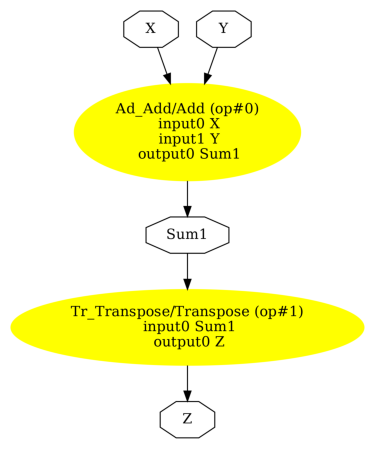

In [16]:
pydot_graph = GetPydotGraph(
    onnx_model2.graph, name=onnx_model2.graph.name, rankdir="TB",
    node_producer=GetOpNodeProducer("docstring", color="yellow",
                                    fillcolor="yellow", style="filled"))
pydot_graph.write_dot("my_model.dot")

os.system('dot -O -Gdpi=300 -Tpng my_model.dot')

image = plt.imread("my_model.dot.png")
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)
ax.axis('off')

In [17]:
sess = ort.InferenceSession(onnx_model2.SerializeToString())
names = [i.name for i in sess.get_inputs()]
dinputs = {name: input for name, input in zip(names, [X_in, Y_in])}
res = sess.run(None, dinputs)
names = [o.name for o in sess.get_outputs()]
prediction = {name: output for name, output in zip(names, res)}

prediction

{'Z': array([[ 0., 22., 44.],
        [11., 33., 55.]], dtype=float32)}

In [18]:
prediction['Z'].shape

(2, 3)

## Three Node Model

In [19]:
from skl2onnx.algebra.onnx_ops import OnnxAdd, OnnxTranspose, OnnxMul

# add to matrices
node1 = OnnxAdd('X','Y', output_names=['Sum1'])  # output_names is opttional

# get negative of the sum
node2 = OnnxMul(node1, np.array([-1]).astype(np.float32))

# add negative sum with original sum, should be all zeros
node3 = OnnxAdd(node1, node2, output_names=['Z'])

# create model from terminal node
onnx_model3 = node3.to_onnx({'X': X, 'Y': Y})

# Check the model, model ok if no messages are generated
onnx.checker.check_model(onnx_model3)
#print(f'the model is:\n{onnx_model3}')

(-0.5, 1531.5, 2734.5, -0.5)

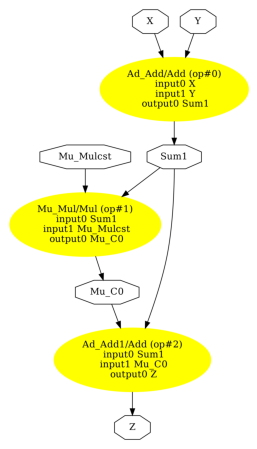

In [20]:
pydot_graph = GetPydotGraph(
    onnx_model3.graph, name=onnx_model3.graph.name, rankdir="TB",
    node_producer=GetOpNodeProducer("docstring", color="yellow",
                                    fillcolor="yellow", style="filled"))
pydot_graph.write_dot("my_model.dot")

os.system('dot -O -Gdpi=300 -Tpng my_model.dot')

image = plt.imread("my_model.dot.png")
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)
ax.axis('off')

In [21]:
# predictions should be all zeroes
sess = ort.InferenceSession(onnx_model3.SerializeToString())
names = [i.name for i in sess.get_inputs()]
dinputs = {name: input for name, input in zip(names, [X_in, Y_in])}
res = sess.run(None, dinputs)
names = [o.name for o in sess.get_outputs()]
prediction = {name: output for name, output in zip(names, res)}

prediction

{'Z': array([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=float32)}

In [22]:
prediction['Z'].shape

(3, 2)